In [1]:
import pyprob
from pyprob.distributions import Normal

import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

## Define a query as a regular Python function

In [2]:
def gaussian(obs, sigma=math.sqrt(2), mu0=1, sigma0=math.sqrt(5)):
    mu = pyprob.sample(Normal(mu0, sigma0))
    mu = pyprob.sample(Normal(mu0, sigma0))
    likelihood = Normal(mu, sigma)
    for o in obs:
        pyprob.observe(likelihood, o)
    return mu

In [3]:
gaussian([], 0.01, 2, 0.01)

1.9868235044959004

## Construct inference from query

In [4]:
model = pyprob.Model(gaussian, default_observes=[1,2])

A lazy prior_sample generator:

In [5]:
s = model.prior_sample([7,9])
type(s)

generator

In [6]:
next(s)

-0.24426186065729838

A collection of samples from prior:

In [7]:
model.prior_samples(10, [])

[-1.890051212575298,
 1.250515073850368,
 1.2974750909146664,
 -1.8346522374558316,
 4.389061678628975,
 -0.8876385331675536,
 4.3562037690733355,
 0.5256650546494073,
 -0.6068757277409431,
 0.1565840415635834]

Inspect traces from prior:

In [8]:
s = model.prior_trace([8, 9])
next(s)

Trace(length:2, samples:[Sample(address_suffixed:12/gaussian.mu_Normal, distribution:Normal(prior_mean:1, prior_std:2.23606797749979, proposal_mean:None, proposal_std:None), value:[2.5708577632904053]), Sample(address_suffixed:28/gaussian.mu_Normal, distribution:Normal(prior_mean:1, prior_std:2.23606797749979, proposal_mean:None, proposal_std:None), value:[2.2682945728302])], observes_tensor:[[8.0], [9.0]], result:2.2682946592826836, log_p:-22.07309997373165)

In [9]:
model.prior_traces(3, [8, 9])

[Trace(length:2, samples:[Sample(address_suffixed:12/gaussian.mu_Normal, distribution:Normal(prior_mean:1, prior_std:2.23606797749979, proposal_mean:None, proposal_std:None), value:[-1.8153499364852905]), Sample(address_suffixed:28/gaussian.mu_Normal, distribution:Normal(prior_mean:1, prior_std:2.23606797749979, proposal_mean:None, proposal_std:None), value:[1.817345142364502])], observes_tensor:[[8.0], [9.0]], result:1.8173451321081453, log_p:-24.98496228864864),
 Trace(length:2, samples:[Sample(address_suffixed:12/gaussian.mu_Normal, distribution:Normal(prior_mean:1, prior_std:2.23606797749979, proposal_mean:None, proposal_std:None), value:[3.4318854808807373]), Sample(address_suffixed:28/gaussian.mu_Normal, distribution:Normal(prior_mean:1, prior_std:2.23606797749979, proposal_mean:None, proposal_std:None), value:[0.7404677867889404])], observes_tensor:[[8.0], [9.0]], result:0.7404678134157829, log_p:-32.761194124287506),
 Trace(length:2, samples:[Sample(address_suffixed:12/gaussian

## Inference with importance sampling

In [10]:
%time empirical_posterior = model.posterior_samples(10000, [8, 9])

CPU times: user 2.36 s, sys: 16 ms, total: 2.38 s
Wall time: 2.37 s


In [11]:
def true_posterior(x):
    p = Normal(7.25, math.sqrt(1/1.2))
    return math.exp(p.log_pdf(x))

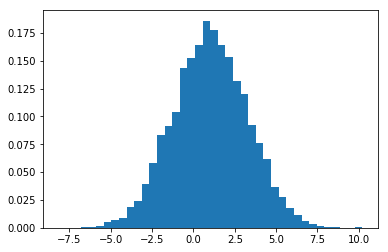

In [12]:
n, bins, patches = plt.hist(empirical_posterior.values,bins=40,normed=True)

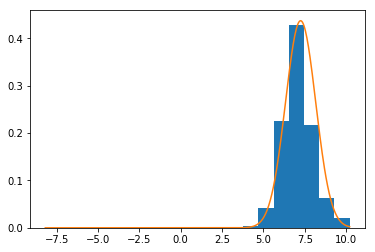

In [13]:
n, bins, patches = plt.hist(empirical_posterior.values, bins=20,weights=empirical_posterior.weights)
x = np.linspace(min(empirical_posterior.values),max(empirical_posterior.values),400)
plt.plot(x, np.vectorize(true_posterior)(x))

## Inference compilation

In [14]:
pyprob.set_cuda(False)
model.learn_proposal(max_traces = 1000)

────────┬─────────────┬───────┬─────────────────┬─────────────────
        │ Train. time │ Trace │ Training loss   │ Valid. loss     
────────┼─────────────┼───────┼─────────────────┼─────────────────
Start   │ 0d:00:00:00 │ 0     │ +8.432357e+00   │ +8.121527e+00
Best    │ 0d:00:00:04 │ 1,536 │ +5.295507e+00   │ +5.689740e+00
Current │ 0d:00:00:04 │ 1,536 │ +5.295507e+00 ▼ │ +5.689740e+00 ▼
────────┴─────────────┴───────┴─────────────────┴─────────────────
Training on CPU, 77  traces/s
Stopped


## Inference with compiled sequential importance sampling

In [15]:
%time empirical_posterior = model.posterior_samples(10000, [8, 9])

CPU times: user 13.4 s, sys: 8.08 s, total: 21.4 s
Wall time: 5.23 s


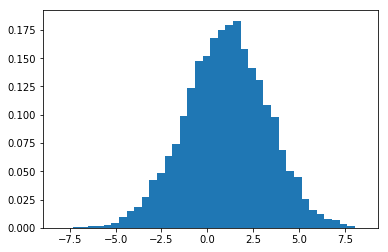

In [16]:
n, bins, patches = plt.hist(empirical_posterior.values,bins=40,normed=True)

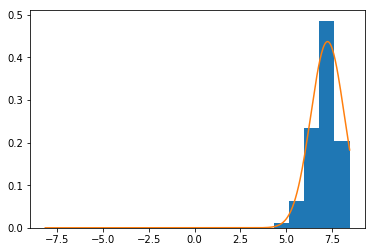

In [17]:
n, bins, patches = plt.hist(empirical_posterior.values, bins=20,weights=empirical_posterior.weights)
x = np.linspace(min(empirical_posterior.values),max(empirical_posterior.values),400)
plt.plot(x, np.vectorize(true_posterior)(x))

In [18]:
samples = np.random.choice(empirical_posterior.values, size=1000, p=empirical_posterior.weights)

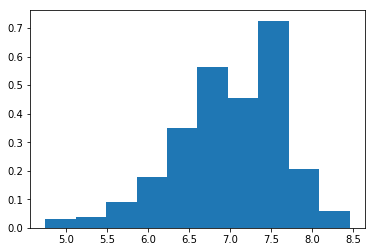

In [19]:
n, bins, patches = plt.hist(samples,bins=10,normed=True)